In [1]:
!pip install torch transformers datasets tokenizers matplotlib nltk evaluate
import torch
import math
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from datasets import load_dataset
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, processors, decoders
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import numpy as np
import nltk
nltk.download('punkt')
nltk.data.path.append('nltk_data')
nltk.download('punkt_tab')

from transformers import get_cosine_schedule_with_warmup

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1')   # Load dataset
print(dataset["train"].column_names)                      # Preview column names
print(dataset["train"][0:5])                              # preview text sample
!nvidia-smi                                               # check for cuda

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

['text']
{'text': ['', ' = Valkyria Chronicles III = \n', '', ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n', " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making t

# EDA
- Distribution of common and rare words using word-level tokenizer
- Estimate mean sentence length

Total sample size: 50000
Sample size without len 0 and 1: 23330 (excluded 26670 sequences)
Mean sequence length (excluding len 0 and 1): 96.75
75th Percentile sequence length: 154.00


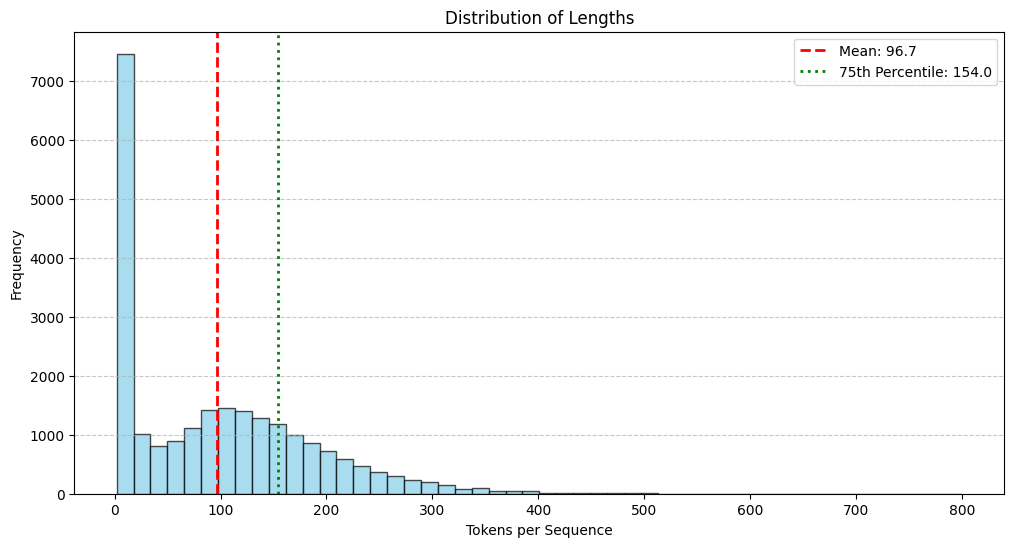

In [3]:
# Calculate average sentence length and 75th percentile (excluding lengths of 0 and 1)
# Measured in BPE tokens

# Train temporary BPE tokenizer
tmp_BPE_tokenizer = Tokenizer(models.BPE())         # empty BPE tokenizer
tmp_trainer = trainers.BpeTrainer(vocab_size=12000, special_tokens=["<pad>", "<unk>", "<bos>", "<eos>"])
tmp_BPE_tokenizer.train_from_iterator(dataset['train'].shuffle(seed=5)[:50000]['text'], trainer=tmp_trainer)

# Calculate lengths with filtering out lengths 0 and 1
lengths = []
for text in dataset['train'].shuffle(seed=6)[:50000]['text']:       # different shuffled subset to avoid data leakage
    tokenized_length = len(tmp_BPE_tokenizer.encode(text).tokens)
    if tokenized_length > 1:                                        # exclude sequences with len 0 or 1 tokens
        lengths.append(tokenized_length)                            # save valid lengths

mean_length = np.mean(lengths)
percentile_75 = np.percentile(lengths, 75)

# Print metrics
print(f"Total sample size: 50000")
print(f"Sample size without len 0 and 1: {len(lengths)} (excluded {50000 - len(lengths)} sequences)")
print(f"Mean sequence length (excluding len 0 and 1): {mean_length:.2f}")
print(f"75th Percentile sequence length: {percentile_75:.2f}")

# Visualize using plt
plt.figure(figsize=(12, 6))
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_length, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_length:.1f}')
plt.axvline(percentile_75, color='green', linestyle=':', linewidth=2, label=f'75th Percentile: {percentile_75:.1f}')
plt.title('Distribution of Lengths')
plt.xlabel('Tokens per Sequence')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [4]:
# Train BPE Tokenizer

# Initialize
bpe_tokenizer = Tokenizer(models.BPE())                         # Instantiate new Tokenizer object using BPE method
bpe_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()        # Set Byte-level pre-tokenizer

# Training rules: 12k vocabulary, Reserve Padding, Unknown, Beginning/End of Sentence special tokens
bpe_trainer = trainers.BpeTrainer(vocab_size=12000, special_tokens=["<pad>", "<bos>", "<eos>", "<unk>"])
bpe_tokenizer.train_from_iterator(dataset['train']['text'], trainer=bpe_trainer)

# Use post processor to add BOS and EOS tokens
bpe_tokenizer.post_processor = processors.TemplateProcessing(
    single="<bos> $A <eos>",
    special_tokens=
        [("<bos>", bpe_tokenizer.token_to_id("<bos>")),
        ("<eos>", bpe_tokenizer.token_to_id("<eos>")),]
    )

bpe_tokenizer.pad_id = bpe_tokenizer.token_to_id("<pad>")

# Confirm reserved special token ids:
print(f"<pad>: {bpe_tokenizer.token_to_id('<pad>')}")
print(f"<bos>: {bpe_tokenizer.token_to_id('<bos>')}")
print(f"<eos>: {bpe_tokenizer.token_to_id('<eos>')}")
print(f"<unk>: {bpe_tokenizer.token_to_id('<unk>')}")


<pad>: 0
<bos>: 1
<eos>: 2
<unk>: 3


# Preprocessing

- Add special tokens
- Segment into fixed sequence length
- Apply sliding window

In [5]:
# Inheriting from torch.utils.data.Dataset
class PDataset(Dataset):

    # Initialize, set default fixed sequence length
    def __init__(self, texts, tokenizer, sequence_length=164):              # Set fixed seq length to ~ 1.5 * average
        self.tokenizer = tokenizer
        self.seq_length = sequence_length
        self.input_ids = self.process_dataset(texts)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        sequence = self.input_ids[idx]
        return torch.tensor(sequence[:-1]), torch.tensor(sequence[1:])      # Create input-target pairs for sliding window
                                                                            # Input: all but last token of sequence, Output: all tokens starting from index 1
    def process_dataset(self, texts):
        sequences = []
        for text in texts:
            tokenized = self.tokenizer.encode(text).ids
            step_size = self.seq_length // 2                # Overlap of 50%
            chunk_length = self.seq_length + 1              # For input/target of length seq_length

            for i in range(0, len(tokenized), step_size):
                chunk = tokenized[i:i + chunk_length]
                if len(chunk) < chunk_length:
                    chunk += [self.tokenizer.pad_id] * (chunk_length - len(chunk))
                sequences.append(chunk)
        return sequences




In [6]:

# Create datasets
train_dataset = PDataset(dataset['train']['text'], bpe_tokenizer)
val_dataset = PDataset(dataset['validation']['text'], bpe_tokenizer)

print(f"Dataset length: {len(train_dataset)}")

Dataset length: 59081


# Positional Encoding

In [7]:
# Sinusoidal positional encoding
class PositionalEncoding(nn.Module):

    def __init__(self, embedding_dim, max_seq_len=4096):
        super().__init__()
        self.embedding_dim = embedding_dim

        position_encodings = torch.zeros(max_seq_len, embedding_dim)                # Initialize positional encoding matrix
        positions = torch.arange(0, max_seq_len, dtype=torch.float32).unsqueeze(1)  # create position indices [0, 1, 2, ..., max_sequence_length-1]

        # Calculate frequency terms for the sinusoidal functions
        # Create alternating sin/cosine frequencies
        # Formula: 1/(10000^(2i/embedding_dim)) for i in [0,2,4, ..., embedding_dim]
        frequency_denominator = torch.exp(torch.arange(0, embedding_dim, 2).float()*(-math.log(10000.0)/embedding_dim))

        # Apply sine to even indices and cosine to odd indices
        position_encodings[:, 0::2] = torch.sin(positions*frequency_denominator) # Even columns: PE(pos, 2_i) = sin(pos*frequency_denominator)
        position_encodings[:, 1::2] = torch.cos(positions*frequency_denominator) # Odd columns: PE(pos, 2_i+1) = cos(pos*frequency_denominator)

        self.register_buffer('position_encodings', position_encodings)

    # Add positional information to input embeddings
    def forward(self, input_tensor):
        seq_length = input_tensor.size(1)
        return self.position_encodings[:seq_length].unsqueeze(0)

# Main Transformer Layers

In [8]:
class DecoderTransformer(nn.Module):

    def __init__(self,
    vocab_size,             # vocabular size (number of unique tokens)
    d_model=256,            # Embedding dimension (size of embedding vector attached to each token)
    nhead=4,                # number of attention heads
    num_layers=4,           # number of transformer decoder layers - times to repeat (attention -> feedforward)
    d_feedforward=1024,     # hidden layer size for feedforward (keep >= d_model)
    max_seq_len=4096,       # maximum sequence length for positional encoding
    dropout=0.05            # Dropout probability (for regularization)
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)                      # embedding layer, creates embedding vectors
        self.pos_embedding = PositionalEncoding(d_model, max_seq_len=max_seq_len)   # Positional embedding layer, adds sequential position information
        self.dropout = nn.Dropout(dropout)

        self.decoder = nn.TransformerEncoder(
            # decoder configuration
            nn.TransformerEncoderLayer(
                d_model,            # Embedding vector dimension
                nhead,              # number of attention heads
                d_feedforward,    # dimension for position-wise feedforward
                dropout,            # dropout regularization to reduce overfitting
                activation='gelu'   # Activation function (RelU -> GelU for better performance)
            ),
            num_layers              # number of decoder layers (creates depth)
        )

        self.fc = nn.Linear(d_model, vocab_size)                   # projection function, map decoder output to vocabulary logits
        self.fc.weight = self.embedding.weight                     # Weight tying, improve performance by sharing weights from embedding
                                                                   # share weights from input embedding layer -> output projection layer

    def generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1)

    # forward pass with causal masking
    def forward(self, x):                          # x = tensor of token indices (int),  shape = (B=batch_size, S=seq_length)
        seq_len = x.size(1)                        # get input sequence length from tensor_shape(B=batch_size, S=seq_length)
        embedded_x = self.embedding(x)             # Get token embeddings (B, S, D=d_model)
        pos_enc = self.pos_embedding(x)            # Get positional encodings (S, D)

        x = embedded_x + pos_enc                   # Combine embeddings and positional encoding (B, S, D) + (S, D)
        x = self.dropout(x)                        # apply dropout

        x = x.permute(1, 0, 2)                     # reorder dimensions for PyTorch Transformer (B, S, D) -> (S, B, D)
        causal_mask = self.generate_square_subsequent_mask(seq_len).to(x.device)       # causal masking to prevent unwanted influence of 'future' embeddings
        x = self.decoder(x, mask=causal_mask)      # apply (attention -> feedforward) num_layer times
        x = x.permute(1, 0, 2)                     # reorder dimensions back (S, B, D) -> (B, S, D)
        return self.fc(x)                          # apply final linear layer to get vocab logits (unnormalized probabilities)



# Training Loop
- switched to AdamW for weight decay

In [9]:
# Training loop

# Parameters
pad_id = 0

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     # use cuda if available
model = DecoderTransformer(vocab_size=12000).to(device)                   # create the model and move to device
# optimizer = optim.Adam(model.parameters(), lr=5e-4)
optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)         # use adamW to apply weight decay independantly from learning rate
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)                      # use cross-entropy loss function, ignore pad tokens
epochs = 30

train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,                # set batch size
    shuffle=True,                 # shuffle each epoch to reduce overfitting
    pin_memory=True               # setting for GPU training
)

steps_per_epoch = len(train_dataloader)             # get steps per epoch
num_training_steps = steps_per_epoch*epochs         # calculate total training steps for scheduler


# print(f"Steps per epoch: {steps_per_epoch}")
# print(f"Total steps: {num_training_steps}")



# learning rate scheduler using a cosine schedule with warmup
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=2500,                         # steps to increase learning rate (linearly) before decay (~1 epoch, 5% of total)
    num_training_steps=num_training_steps          # total training steps
)

# epoch loop
for epoch in range(epochs):
    model.train()               # set model to training mode
    total_loss = 0.0            # cumulative loss
    total_tokens = 0            # count non-padding tokens

    for inputs, targets in train_dataloader:                        # Batch iteration
        inputs, targets = inputs.to(device), targets.to(device)     # GPU transfer

        outputs = model(inputs)                                                     # Forward pass
        loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))      # calculate loss (ignore pad tokens)

        loss.backward()                                                             # Backpropagate gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()                                                            # Update weights
        scheduler.step()                                                            # Update learning rate
        optimizer.zero_grad()                                                       # Reset gradients

        # Update metric trackers
        non_pad_tokens = (targets!=pad_id).sum().item()                             # only count non-pad tokens
        total_loss += (loss.item()*non_pad_tokens)                                  # total loss = current loss * tokens
        total_tokens += non_pad_tokens                                              # update total (non pad) token count

    avg_loss = total_loss/total_tokens                                              # averate loss per token
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')                      # print loss for current epoch

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/30], Loss: 13.1727
Epoch [2/30], Loss: 6.3563
Epoch [3/30], Loss: 5.6953
Epoch [4/30], Loss: 5.3734
Epoch [5/30], Loss: 5.1647
Epoch [6/30], Loss: 5.0090
Epoch [7/30], Loss: 4.8814
Epoch [8/30], Loss: 4.7741
Epoch [9/30], Loss: 4.6799
Epoch [10/30], Loss: 4.5965
Epoch [11/30], Loss: 4.5199
Epoch [12/30], Loss: 4.4506
Epoch [13/30], Loss: 4.3869
Epoch [14/30], Loss: 4.3280
Epoch [15/30], Loss: 4.2731
Epoch [16/30], Loss: 4.2234
Epoch [17/30], Loss: 4.1760
Epoch [18/30], Loss: 4.1326
Epoch [19/30], Loss: 4.0925
Epoch [20/30], Loss: 4.0560
Epoch [21/30], Loss: 4.0224
Epoch [22/30], Loss: 3.9924
Epoch [23/30], Loss: 3.9667
Epoch [24/30], Loss: 3.9432
Epoch [25/30], Loss: 3.9235
Epoch [26/30], Loss: 3.9083
Epoch [27/30], Loss: 3.8955
Epoch [28/30], Loss: 3.8870
Epoch [29/30], Loss: 3.8808
Epoch [30/30], Loss: 3.8777


# Evaluation

In [10]:
# Evaluate Perplexity on training and validation dataset to determine model performance and check for overfitting


# Set model to evaluation mode (disables dropout and training layers)
model.eval()

# Set loss function (sum reduction for manual normalization)
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_id, reduction='sum')

# Create DataLoaders for train and val splits
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Function to calculate perplexity
def calculate_perplexity(data_loader):
    total_loss = 0.0                      # Track total loss
    total_tokens = 0                      # Track token count

    with torch.no_grad():                                               # no gradient calculations for evaluation
        for inputs, targets in data_loader:                             # loop through batches of inputs and targets
            inputs, targets = inputs.to(device), targets.to(device)     # move data to device
            outputs = model(inputs)                                                     # Forward pass to get predictions
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))      # Calculate loss

            # Count non-pad tokens
            non_pad_tokens = (targets != 0).sum().item()
            total_loss += loss.item()
            total_tokens += non_pad_tokens

    # case: empty dataset
    if total_tokens == 0:
        return float('inf')

    return torch.exp(torch.tensor(total_loss / total_tokens)).item()

# Calculate perplexities for both datasets
train_perplexity = calculate_perplexity(train_loader)
val_perplexity = calculate_perplexity(val_loader)

print(f"Training Perplexity: {train_perplexity:.2f}")
print(f"Validation Perplexity: {val_perplexity:.2f}")

Training Perplexity: 33.47
Validation Perplexity: 137.99


In [ ]:
def calculate_accuracy(data_loader):
    total_correct = 0
    total_tokens = 0

    model.eval()
    with torch.no_grad():

        # Iterate through batches
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)        # move data to GPU
            outputs = model(inputs)                                        # forward pass: get model predictions

            # Flatten outputs and targets
            outputs_flat = outputs.view(-1, outputs.shape[-1])      # outputs shape: (batch_size*seq_len, vocab_size)
            targets_flat = targets.view(-1)                         # targets shape: (batch_size*seq_len)

            predictions = torch.argmax(outputs_flat, dim=-1)        # select max prob. to get predicted tokens

            # Use masking to remove pads
            pad_mask = (targets_flat!=pad_id)                       # create mask
            non_pad_targets = targets_flat[pad_mask]                # apply mask
            non_pad_predictions = predictions[pad_mask]

            # Update counts
            total_correct += (non_pad_predictions==non_pad_targets).sum().item()
            total_tokens += pad_mask.sum().item()

    return (total_correct/total_tokens)*100                                           # Return accuracy as percentage

In [15]:
# Wikitext2 accuracy
train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)
print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Train Accuracy: 37.49%
Validation Accuracy: 25.33%


In [17]:
# Validate on tinystories for generalization test
tiny_stories_val = load_dataset('roneneldan/TinyStories', split='validation')  # Load TinyStories validation split
tiny_stories_val_dataset = PDataset(tiny_stories_val['text'], bpe_tokenizer)           # Preprocess TinyStories dataset

tiny_stories_loader = DataLoader(tiny_stories_val_dataset, batch_size=16, shuffle=False)
tiny_perplexity = calculate_perplexity(tiny_stories_loader)
print(f"TinyStories Perplexity: {tiny_perplexity:.2f}")

TinyStories Perplexity: 4120.70


In [13]:
# check for tokenization issues
sample = tiny_stories_val[0]['text']
tokenized = bpe_tokenizer.encode(sample)
print("Tokenized:", tokenized.tokens)
print("Number of <unk>:", tokenized.ids.count(bpe_tokenizer.token_to_id("<unk>")))

Tokenized: ['<bos>', 'ĠSp', 'ot', '.', 'ĠSp', 'ot', 'Ġsaw', 'Ġthe', 'Ġsh', 'iny', 'Ġcar', 'Ġand', 'Ġsaid', ',', 'Ġ"', 'W', 'ow', ',', 'ĠKit', 'ty', ',', 'Ġyour', 'Ġcar', 'Ġis', 'Ġso', 'Ġbright', 'Ġand', 'Ġclean', '!', '"', 'ĠKit', 'ty', 'Ġsm', 'iled', 'Ġand', 'Ġreplied', ',', 'Ġ"', 'T', 'h', 'ank', 'Ġyou', ',', 'ĠSp', 'ot', '.', 'ĠI', 'Ġpol', 'ish', 'Ġit', 'Ġevery', 'Ġday', '.', '"', 'Ċ', 'Ċ', 'A', 'fter', 'Ġplaying', 'Ġwith', 'Ġthe', 'Ġcar', ',', 'ĠKit', 'ty', 'Ġand', 'ĠSp', 'ot', 'Ġfelt', 'Ġth', 'irst', 'y', '.', 'ĠThey', 'Ġfound', 'Ġa', 'Ġsmall', 'Ġp', 'ond', 'Ġwith', 'Ġclear', 'Ġwater', '.', 'ĠThey', 'Ġd', 'ran', 'k', 'Ġthe', 'Ġwater', 'Ġand', 'Ġfelt', 'Ġvery', 'Ġhappy', '.', 'ĠThey', 'Ġplayed', 'Ġtogether', 'Ġall', 'Ġday', 'Ġand', 'Ġbecame', 'Ġbest', 'Ġfriends', '.', '<eos>']
Number of <unk>: 0


In [ ]:
# Gridsearch


import itertools
import torch
from torch.utils.data import DataLoader
from torch import nn, optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#hyperparameter grid
param_grid = {
    'learning_rate': [3e-4, 5e-4],
    'num_layers': [4],
    'num_heads': [4, 8],
    'dropout': [0.1]
}

# Generate combinations
keys = param_grid.keys()
values = param_grid.values()
combinations = [dict(zip(keys, combo)) for combo in itertools.product(*values)]

vocab_size = 10000
pad_token_id = 0

results = []

for combo in combinations:
    print(f"\nTraining with: {combo}")

    # Initialize model
    model = DecoderTransformer(vocab_size=vocab_size,
    num_layers=combo['num_layers'], nhead=combo['num_heads'], dropout=combo['dropout'] ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=combo['learning_rate'])
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_token_id)

    for epoch in range(2):
        model.train()            # set model back to train after eval
        total_loss = 0
        total_tokens = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            loss.backward()
            optimizer.step()

            non_pad_tokens = (targets!=pad_token_id).sum().item()
            total_loss += loss.item()*non_pad_tokens
            total_tokens += non_pad_tokens

        epoch_loss = total_loss / total_tokens if total_tokens else 0
        print(f"Epoch {epoch+1} loss: {epoch_loss:.4f}")

    # Perplexity calculation (per epoch)
    model.eval()                  # set model to eval for validation
    total_loss = 0
    total_tokens = 0
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))

            non_pad = (targets != pad_token_id).sum().item()
            total_loss += loss.item()
            total_tokens += non_pad

    # Calculate perplexity, special case for empty
    perplexity = torch.exp(torch.tensor(total_loss/total_tokens)).item() if total_tokens else float('inf')
    results.append((combo, perplexity))
    print(f"Config: {combo} | Perplexity: {perplexity:.2f}")